In [3]:
import sys
import os
# os.environ['JAX_PLATFORM_NAME'] = 'cpu'

import numpy as np
import numba
import time

# Add the parent directory (project root) to sys.path
script_dir = os.path.dirname(os.curdir)
parent_dir = os.path.abspath(os.path.join(script_dir, '..', '..'))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

# ------------------------------------------------------------------
#! General
from QES.general_python.common.binary import get_global_logger
from QES.general_python.common.timer import Timer, timeit
from QES.general_python.common.binary import get_global_logger, Array
from QES.general_python.common import Plotter, MatrixPrinter, colorsCycle, linestylesCycle
from QES.general_python.common import Directories
from QES.general_python.common import HDF5Handler
from QES.general_python.maths.statistics import HistogramAverage, Fraction

# ------------------------------------------------------------------
from QES.Algebra.Model.Interacting.Spin.ultrametric import UltrametricModel
from QES.Algebra.hilbert import HilbertSpace

# ------------------------------------------------------------------
from QES.Algebra.Properties import time_evo
from QES.Algebra.Properties import statistical
from QES.general_python.algebra.linalg import act, overlap, overlap_diag

# ------------------------------------------------------------------
import QES.Algebra.Operator.operators_spin as op_spin

logger      = get_global_logger()

# ------------------------------------------------------------------
data_dir = Directories(os.curdir, 'data')
data_dir.mkdir()


20_05_2025_13-30_10 [INFO] Log file created: ./log/QES_20_05_2025_13-30_10.log
20_05_2025_13-30_10 [INFO] Log level set to: info
20_05_2025_13-30_10 [INFO] ############Global logger initialized.############
20_05_2025_13-30_10 [INFO] JAX backend available and successfully imported
20_05_2025_13-30_10 [INFO] 	JAX 64-bit precision enabled.
20_05_2025_13-30_10 [INFO] Setting JAX as the active backend.
20_05_2025_13-30_10 [INFO] **************************************************
20_05_2025_13-30_10 [INFO] Backend Configuration:
20_05_2025_13-30_10 [INFO] 		NumPy Version: 1.26.4
20_05_2025_13-30_10 [INFO] 		SciPy Version: 1.13.1
20_05_2025_13-30_10 [INFO] 		JAX Version: 0.6.0
20_05_2025_13-30_10 [INFO] 		Active Backend: jax
20_05_2025_13-30_10 [INFO] 			JAX Available: True
20_05_2025_13-30_10 [INFO] 			Default Seed: 42
20_05_2025_13-30_10 [INFO] 		JAX Backend Details:
20_05_2025_13-30_10 [INFO] 				Main Module: jax.numpy
20_05_2025_13-30_10 [INFO] 				Random Module: jax.random (+ PRNGKey)
2

Directories(PosixPath('data'))

### Operator functions

In [4]:
sig_z_0 = lambda ns: op_spin.sig_z(
    ns      = ns,
    type_act= op_spin.OperatorTypeActing.Global,
    sites   = [0]
)
sig_z_c = lambda ns: op_spin.sig_z(
    ns      = ns,
    type_act= op_spin.OperatorTypeActing.Global,
    sites   = [0, 1]
)
sig_z_l = lambda ns: op_spin.sig_z(
    ns      = ns,
    type_act= op_spin.OperatorTypeActing.Local,
    sites   = [ns-1]
)

### Model test

20_05_2025_13-30_11 [INFO] 	->[Hamiltonian] Diagonalization started using (standard)...
20_05_2025_13-30_11 [INFO] 		->[Hamiltonian] Diagonalization (standard) completed in 0.145346 seconds.


Ultrametric(ns=10,N=3,J=1.0,g=1.0,a=0.800)

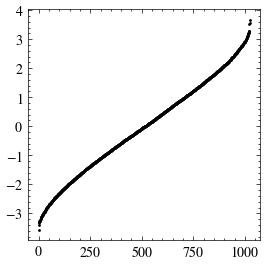

In [5]:
fig, ax = Plotter.get_subplots(1, 1, figsize=(3, 3))

model   = UltrametricModel(
    ns      = 10,
    n       = 3,
    alphas  = 0.8,
    backend = np
)

model.build()
model.diagonalize(verbose=True)

ax[0].plot(model.eig_val, 'o', ms = 1, color='black', label='Eigenvalues')
model

### Go through the model

In [6]:
@numba.njit(parallel=True, fastmath=True)
def f_function( start           : int,
                stop            : int,
                overlaps        : np.ndarray,
                eigvals         : np.ndarray,
                omegas_allocated: np.ndarray,
                vals_allocated  : np.ndarray,
                energy_target   : float = 0.0,
                bw              : float = 1.0,
                energy_diff_cut : float = 0.015):
    tol         = bw * energy_diff_cut
    omegas      = omegas_allocated
    vals        = vals_allocated
    cnt         = 0
    nh          = len(eigvals)
    for ii in numba.prange(start, stop):
        en_i = eigvals[ii]
        for jj in range(ii+1, nh):
            # inline is_close_target:
            if abs((en_i + eigvals[jj])*0.5 - energy_target) >= tol:
                continue

            # compute and store
            omega       = abs(en_i - eigvals[jj])
            m2          = abs(overlaps[ii, jj])**2
            omegas[cnt] = omega
            vals[cnt]   = m2
            cnt        += 1
            
    return cnt

@numba.njit(parallel=True, fastmath=True)
def f_function_indices( start           : int,
                        stop            : int,
                        eigvals         : np.ndarray,
                        indices_i       : np.ndarray,
                        indices_j       : np.ndarray,
                        energy_target   : float = 0.0,
                        bw              : float = 1.0,
                        energy_diff_cut : float = 0.015):
    tol         = bw * energy_diff_cut
    i_idx       = indices_i
    j_idx       = indices_j
    cnt         = 0
    nh          = len(eigvals)
    for ii in numba.prange(start, stop):
        en_i = eigvals[ii]
        for jj in range(ii+1, nh):
            # inline is_close_target:
            if abs((en_i + eigvals[jj])*0.5 - energy_target) >= tol:
                continue
            i_idx[cnt]  = ii
            j_idx[cnt]  = jj
            cnt        += 1
            
    return i_idx[:cnt], j_idx[:cnt]

# @numba.njit(parallel=True, fastmath=True)
def f_function_from_indices(
        idx_i               : np.ndarray,
        idx_j               : np.ndarray,
        overlaps            : np.ndarray,
        eigvals             : np.ndarray,
    ):
    omegas      = np.abs(eigvals[idx_i] - eigvals[idx_j])
    vals        = overlaps[idx_i, idx_j].flatten()**2
    return omegas, vals


In [7]:
alphas          = np.arange(0.6, 1.0, 0.15)
sites           = np.arange(6, 14, dtype=int)
# sites           = np.arange(6, 7, dtype=int)
# n_realisations  = {ns: 1 for ns in sites}
n_realisations  = {ns: 5 * (10 * (np.max(sites) - np.min(sites)) - 10 * (ns - np.min(sites)) + 1) for ns in sites}
time_num        = 20000

logger.info(f"Number of realisations: {n_realisations}")
logger.info(f"Number of sites: {len(sites)}")
logger.info(f"Alphas: {alphas}")
logger.info(f"Sites: {sites}")


20_05_2025_13-30_11 [INFO] Number of realisations: {6: 355, 7: 305, 8: 255, 9: 205, 10: 155, 11: 105, 12: 55, 13: 5}
20_05_2025_13-30_11 [INFO] Number of sites: 8
20_05_2025_13-30_11 [INFO] Alphas: [0.6  0.75 0.9 ]
20_05_2025_13-30_11 [INFO] Sites: [ 6  7  8  9 10 11 12 13]


In [9]:

#! -------------------------------------------------------

operators_map = {
    sig_z_0(0).name : sig_z_0,
    sig_z_c(0).name : sig_z_c,
}

#! -------------------------------------------------------
# prepare the 3-level containers:
#   histograms_av[op][alpha][ns] → HistogramAverage
histograms_av  = {
    op: {alpha: {} for alpha in alphas}
    for op in operators_map
}
histograms_typ = {
    op: {alpha: {} for alpha in alphas}
    for op in operators_map
}
bandwidths    = {
    alpha: [] for alpha in alphas
}

#! -------------------------------------------------------
uniform  = True
rand_num = np.random.randint(0, int(1e5)) # for all iterations
for ins, ns in enumerate(sites):
    logger.info(f"ns = {ns}", lvl=1, color='blue')
    
    hilbert_size        = 2**ns
    # operators_map[sig_z_l(ns).name] = sig_z_l
    operators           = {k: v(ns) for k, v in operators_map.items()}
    operators           = {v.name : v for k, v in operators.items()}
    op_mats             = {k : op.matrix(dim=hilbert_size) for k, op in operators.items()}
    max_allocated       = hilbert_size * (hilbert_size - 1) // 2
    omegas_allocated    = np.zeros(max_allocated, dtype=np.float64)
    vals_allocated      = np.zeros(max_allocated, dtype=np.float64)
    # i_idx_allocated      = np.zeros(max_allocated, dtype=np.int64)
    # j_idx_allocated      = np.zeros(max_allocated, dtype=np.int64)
    
    #! pre-allocate the values to save
    n_realisations_in   = n_realisations[ns]
    
    ldos                = np.zeros(shape=(n_realisations_in, hilbert_size), dtype=np.float64)
    energies            = np.zeros(shape=(n_realisations_in, hilbert_size), dtype=np.float64)
    diagonals_operators = { k : np.zeros(shape=(n_realisations_in, hilbert_size), dtype=np.float64) for k in operators.keys()   }
    
    #! time evolution
    if uniform:
        time_start  = hilbert_size * 0.01
        time_delta  = 1.0 / hilbert_size
        time_steps  = np.linspace(time_start, time_start + time_delta * time_num, num=time_num)
    else:
        time_steps  = np.logspace(-2, np.log10(hilbert_size * 5), num=time_num)
    
    time_vals           = { k : np.zeros(shape=(n_realisations_in, time_num), dtype=np.complex128) for k in operators.keys()    }
    overlaps            = np.zeros(shape=(hilbert_size,), dtype=np.float64)
    diagonal_ensemble_in= { k : np.zeros(shape=(n_realisations_in,), dtype=np.float64) for k in operators.keys() }
    quench_state        = np.zeros(shape=(hilbert_size,), dtype=np.float64)
    quench_states_t     = np.zeros(shape=(time_num, hilbert_size), dtype=np.complex128)
    idx                 = 0
    #! go through the alphas
    for alpha in alphas:
        logger.info(f"ns = {ns}, alpha = {alpha:.2f}", lvl=2, color='green')
        
        
        # placeholders for this (ns,alpha)
        bandwidth = None
        h_av      = {}
        h_typ     = {}
        model     = UltrametricModel(
                        ns      = ns,
                        n       = 1,
                        alphas  = alpha,
                        backend = np,
                        seed    = None,
                    )
        
        for r in range(n_realisations_in):
            logger.info(f"ns = {ns}, alpha = {alpha:.2f}, r = {r}", lvl=3, color='red')
            data_dir_in = data_dir.join('uniform' if uniform else 'log', f'{str(model)}')
            data_dir_in.mkdir()
            
            #! build & diag
            model.clear()
            model.build()
            model.diagonalize(verbose=True)
            mean_energy     = model.av_en
            bandwidth       = model.get_bandwidth()
            bandwidths[alpha].append(bandwidth)
            
            #! select the quench state
            if True:
                quench_state[idx]       = 0.0
                diff                    = np.abs(model.eig_val - mean_energy)
                idx                     = int(np.argmin(diff))
                quench_state[idx]       = 1.0
                overlaps                = model.eig_vec.T @ quench_state
                quench_states_t         = time_evo.time_evo_block(model.eig_vec, model.eig_val,
                                                    quench_overlaps=overlaps, times=time_steps)
                
            #! compute the ldos
            if True:
                ldos[r, :]              = statistical.ldos(energies = model.eig_val, overlaps = overlaps)
                energies[r, :]          = model.eig_val
                
            #! on first realisation, init histograms
            if bandwidth is None or r == 0:
                o_max     = 3 * bandwidth
                o_min     = 0.01 / model.hilbert_size
                n_bins    = int(20 * np.log2(model.hilbert_size))
                edges     = HistogramAverage.uniform_log(n_bins, v_max=o_max, v_min=o_min)
                for name in operators.keys():
                    h_av[name]  = HistogramAverage(n_bins, edges=edges)
                    h_typ[name] = HistogramAverage(n_bins, edges=edges)
            
            #! accumulate into the single histogram
            if True:
                for name in operators.keys():
                    matrix_elements                 = overlap(model.eig_vec, op_mats[name])
                    diagonals_operators[name][r, :] = matrix_elements.diagonal()
                    diagonal_ensemble_in[name][r]   = time_evo.diagonal_ensemble(soverlaps=overlaps**2, diag_mat=matrix_elements.diagonal())

                    cnt = f_function(
                        start               = 0,
                        stop                = len(model.eig_vec),
                        overlaps            = matrix_elements,
                        eigvals             = model.eig_val,
                        omegas_allocated    = omegas_allocated,
                        vals_allocated      = vals_allocated,
                        energy_target       = mean_energy,
                        bw                  = bandwidth,
                        energy_diff_cut     = 0.05)
                    
                    #! remove zeros and nan
                    omegas  = omegas_allocated[:cnt]
                    vals    = vals_allocated[:cnt]
                    mask    = np.logical_and(vals > 1e-10, np.isfinite(vals))
                    omegas  = omegas[mask]
                    vals    = vals[mask]
                    h_av[name].append(omegas, vals)
                    h_typ[name].append(omegas, np.log(vals))
                    
                    #! time evolution
                    quenched_values_t       = time_evo.time_evo_evaluate(quench_states_t, op_mats[name])
                    time_vals[name][r, :]   = quenched_values_t

        #! store the combined histogram for this (ns,alpha)
        for name in operators:
            histograms_av[name][alpha][ns] = h_av[name]
            histograms_typ[name][alpha][ns] = h_typ[name]
            # histograms_typ[k][alpha].append(histogram_typ)
            
        #! save the data
        if True:
            data_stat = {
                'bandwidth' : bandwidth,
                'energies'  : energies,
                'ldos'      : ldos,
            }
            data_hist = {
                'historgram/edges'  : histograms_av[name][alpha][ns].bin_edges,
                'historgram/counts' : histograms_av[name][alpha][ns].counts(),
            }
            for name in operators.keys():
                data_hist.update({
                    f'historgram/{name}/average/values' : histograms_av[name][alpha][ns].averages_av(),
                    f'historgram/{name}/typical/values' : histograms_av[name][alpha][ns].averages_av(is_typical=True),
                })
            #! statistical
            HDF5Handler.save_hdf5(directory =   data_dir_in, 
                                filename    =   f'stat_{rand_num}.h5',
                                data        =   data_stat)
            #! operator
            data_op = {
                op : diag for op, diag in diagonals_operators.items()
            }
            HDF5Handler.save_hdf5(directory =   data_dir_in,
                                filename    =   f'diag_{rand_num}.h5', 
                                data        =   data_op)
            
            #! time evolution
            data_time = {
                'time'              : time_steps
            }
            data_time.update({
                f'time_evolution/{name}/expectation' : time_vals[name] for name in operators.keys()
            })
            data_time.update({
                f'time_evolution/{name}/diag_ens' : diagonal_ensemble_in[name] for name in operators.keys()
            })
            HDF5Handler.save_hdf5(directory =   data_dir_in,
                                filename    =   f'evo_{rand_num}.h5', 
                                data        =   data_time)


20_05_2025_13-30_28 [INFO] 	->ns = 6
20_05_2025_13-30_28 [INFO] 		->[HilbertSpace] Inferred Ns=6 from Nh=64 and Nhl=2
20_05_2025_13-30_28 [INFO] 		->[HilbertSpace] Inferred Ns=6 from Nh=64 and Nhl=2
20_05_2025_13-30_29 [INFO] 		->ns = 6, alpha = 0.60
20_05_2025_13-30_29 [INFO] 			->ns = 6, alpha = 0.60, r = 0
20_05_2025_13-30_29 [INFO] 		->[Hamiltonian] Hamiltonian cleared...
20_05_2025_13-30_29 [INFO] 	->[Hamiltonian] Diagonalization started using (standard)...
20_05_2025_13-30_29 [INFO] 		->[Hamiltonian] Diagonalization (standard) completed in 0.000671 seconds.
20_05_2025_13-30_29 [INFO] 			->ns = 6, alpha = 0.60, r = 1
20_05_2025_13-30_29 [INFO] 		->[Hamiltonian] Hamiltonian cleared...
20_05_2025_13-30_29 [INFO] 	->[Hamiltonian] Diagonalization started using (standard)...
20_05_2025_13-30_29 [INFO] 		->[Hamiltonian] Diagonalization (standard) completed in 0.000602 seconds.
20_05_2025_13-30_29 [INFO] 			->ns = 6, alpha = 0.60, r = 2
20_05_2025_13-30_29 [INFO] 		->[Hamiltonian] Hamilt

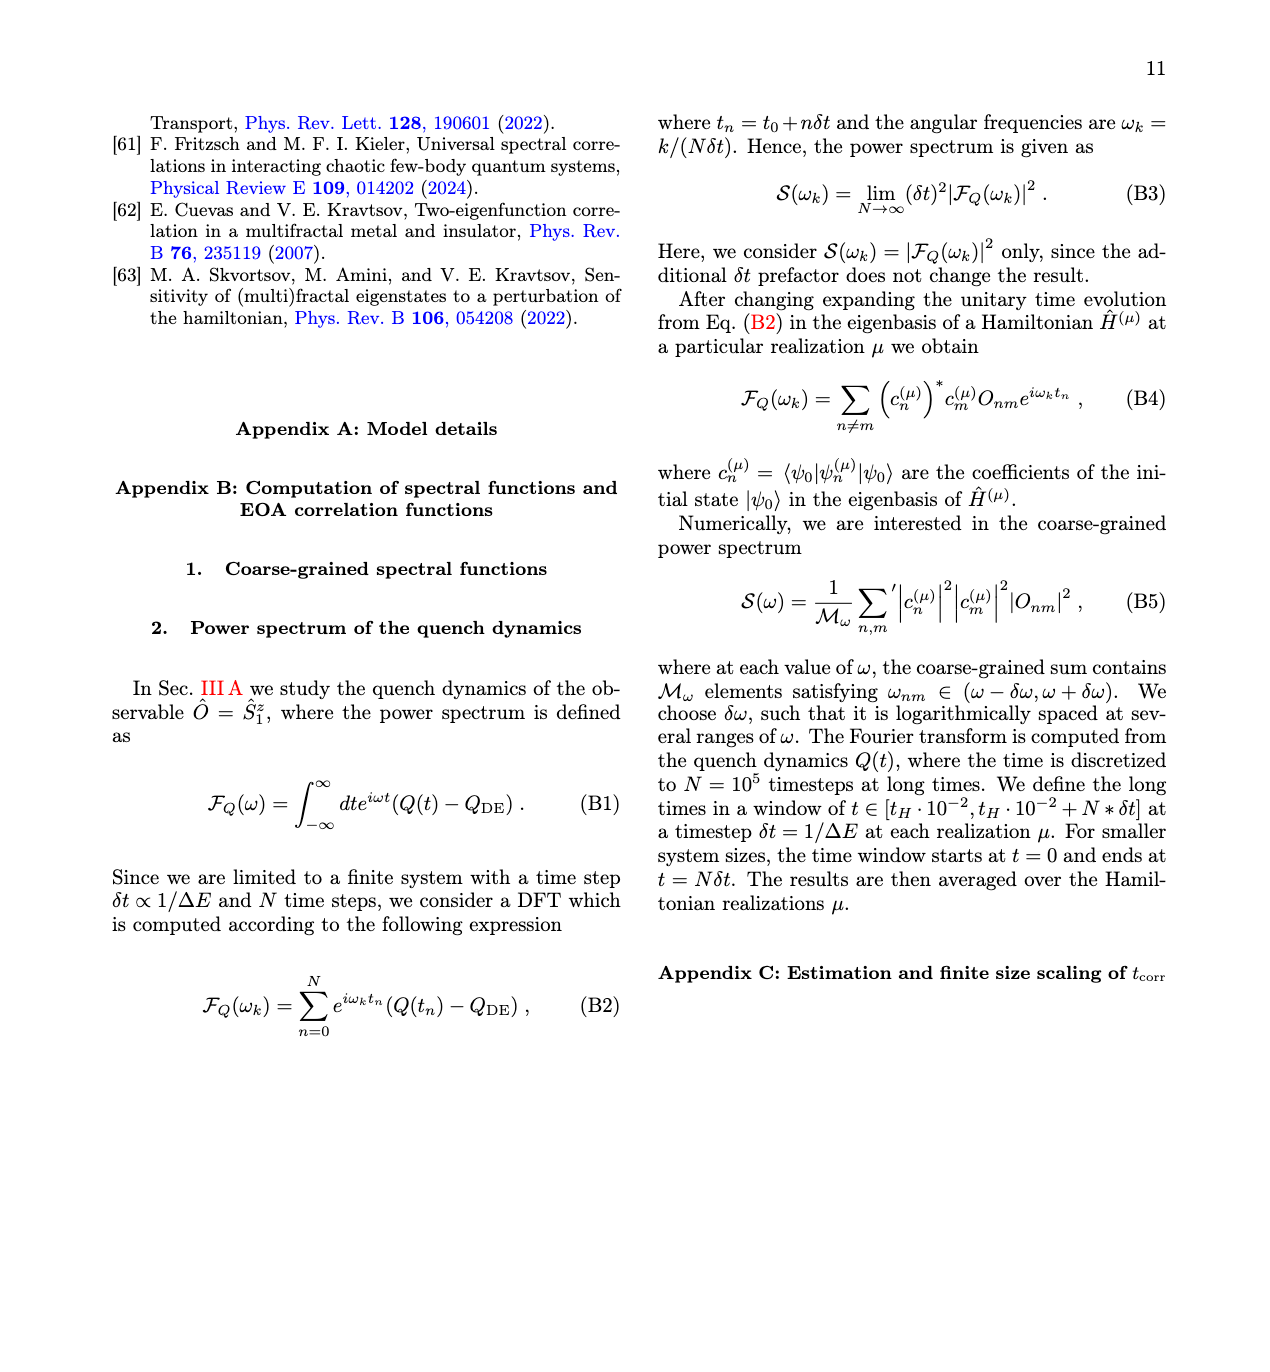

/tmp/ipykernel_3516802/4064633467.py:51: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axis.legend(frameon=True, loc='upper right', fontsize=6)
/tmp/ipykernel_3516802/4064633467.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


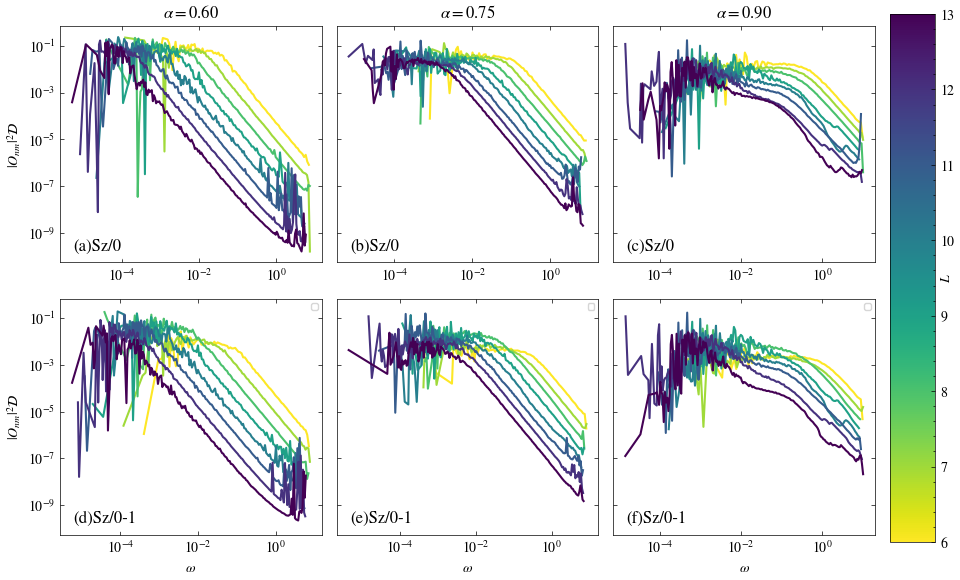

In [13]:
fig, ax = Plotter.get_subplots(
    nrows    = len(operators_map),
    ncols    = len(alphas),
    figsize  = (3*len(alphas), 3*len(operators_map)),
    sharey   = True
)
getcolor, colors, norm = Plotter.get_colormap(sites, cmap='viridis_r')
Plotter.add_colorbar_pos(fig, colors, 
                        mapable =    sites,
                        pos     =   (1.0, 0.08, 0.05, 0.88), ylabel=r'$L$', ylabelcords=(1.1, 0.5)
                    )
typical = False

for op_idx, (op_name, _) in enumerate(operators_map.items()):
    for alpha_idx, alpha in enumerate(alphas):
        idx_ax  = op_idx * len(alphas) + alpha_idx
        axis    = ax[idx_ax]
        Plotter.set_annotate_letter(axis, idx_ax, x = 0.05, y = 0.05, addit = op_name)
        #! plot each ns into the same histogram
        for ns in sites:
            h : HistogramAverage    = (histograms_typ if typical else histograms_av)[op_name][alpha][ns]
            vals                    = h.averages_av()
            # counts                  = h.counts_col()
            # one mask for >0, finite
            if not typical:
                mask = (vals > 1e-10) & np.isfinite(vals)
            else:
                mask = (vals < -1e-10) & np.isfinite(vals)
            if not mask.any():
                continue
            if typical:
                vals = np.exp(vals) * 2**ns

            axis.plot(h.bin_edges[mask], vals[mask], lw=1.5, color=getcolor(ns))

        # log–log and fixed y-range
        axis.set_xscale('log')
        axis.set_yscale('log')
        # axis.set_ylim(1e-4, None)

        # only bottom row gets the x-label
        if op_idx == len(operators_map) - 1:
            axis.set_xlabel(r'$\omega$')

        # only first column gets the y-label
        if alpha_idx == 0:
            axis.set_ylabel(r'$|O_{nm}|^2 \mathcal{D}$')

        # legend in bottom of each column (or top-right of bottom row)
        if op_idx == len(operators_map) - 1:
            axis.legend(frameon=True, loc='upper right', fontsize=6)

        # optional: put alpha in the column title on top row
        if op_idx == 0:
            axis.set_title(f"$\\alpha = {alpha:.2f}$")

fig.tight_layout()
